##### 氣象機器人 (3) - 天氣預報和空氣品質
延續「氣象機器人 (2) - 目前氣象資訊」文章，這篇教學會讓 LINE 氣象機器人串接天氣預報和空氣品質資訊，\
只要使用 LINE 預設的功能提供地址，就能回傳該地址的天氣預報和空氣品質資訊。

爬取天氣預報資訊 
參考「[爬取天氣預報](https://steam.oxxostudio.tw/category/python/spider/forecast.html)」教學，從氣象資料開放平臺裡，找到「一般天氣預報-今明36小時天氣預報」資料集。

資料連結 ( 需要登入才看得到 JSON 連結 )
* [一般天氣預報-今明36小時天氣預報](https://opendata.cwa.gov.tw/dataset/forecast/F-C0032-001)

使用 API 的方法，可以得到下方的網址，網址中會出現四組參數：
* elementName：查詢的資料為 WeatherDescription 天氣描述。
* Authorization：使用者的氣象 API Token。
* timeFrom：起始時間 ( 通常使用當下的時間 )。
* timeTo：搭配起始時間，最少為起始時間後三小時。

In [ ]:
url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/{area ID}?Authorization={user Token}&elementName=WeatherDescription&timeFrom={now}&timeTo={now2}'

下方程式執行後，會根據所在地的「縣市」取得對應的縣市代碼，接著再下載對應的數據。

* 如果使用 Colab 實作，因為時區的緣故，必須額外加上 28800 秒 ( 八小時 )，本機環境則不需要。

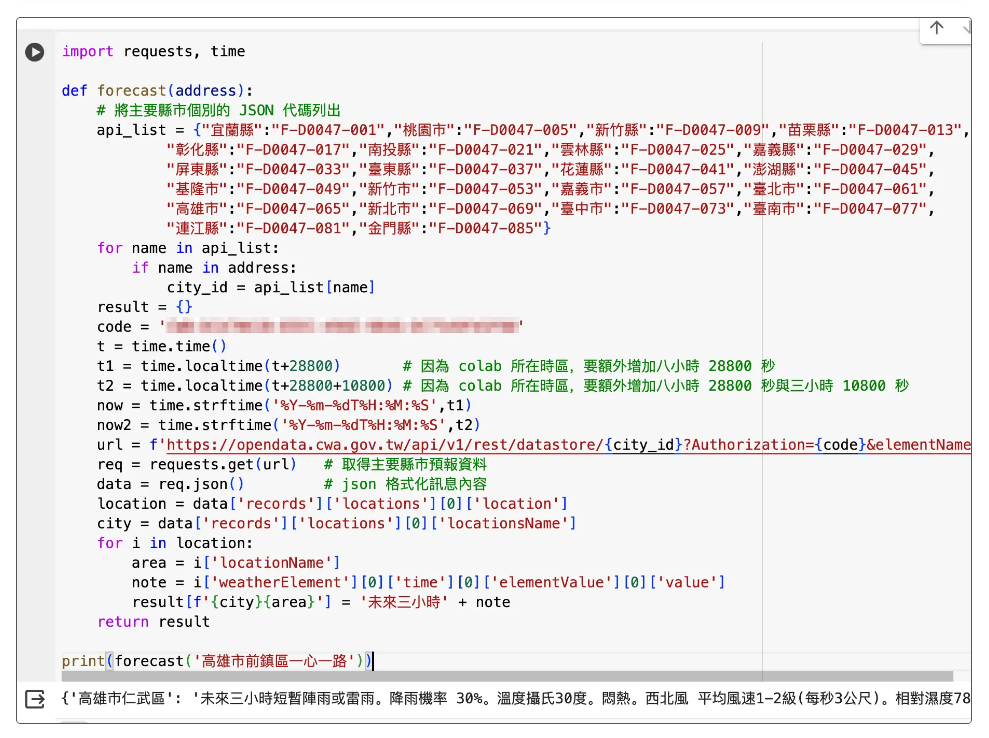

In [ ]:
import requests, time

def forecast(address):
    # 將主要縣市個別的 JSON 代碼列出
    api_list = {"宜蘭縣":"F-D0047-001","桃園市":"F-D0047-005","新竹縣":"F-D0047-009","苗栗縣":"F-D0047-013",
            "彰化縣":"F-D0047-017","南投縣":"F-D0047-021","雲林縣":"F-D0047-025","嘉義縣":"F-D0047-029",
            "屏東縣":"F-D0047-033","臺東縣":"F-D0047-037","花蓮縣":"F-D0047-041","澎湖縣":"F-D0047-045",
            "基隆市":"F-D0047-049","新竹市":"F-D0047-053","嘉義市":"F-D0047-057","臺北市":"F-D0047-061",
            "高雄市":"F-D0047-065","新北市":"F-D0047-069","臺中市":"F-D0047-073","臺南市":"F-D0047-077",
            "連江縣":"F-D0047-081","金門縣":"F-D0047-085"}
    for name in api_list:
        if name in address:
            city_id = api_list[name]   # 根據提供的地址，取得縣市代碼
    result = {}
    code = '你的氣象 token'
    t = time.time()
    t1 = time.localtime(t+28800)       # 因為 colab 所在時區，要額外增加八小時 28800 秒
    t2 = time.localtime(t+28800+10800) # 因為 colab 所在時區，要額外增加八小時 28800 秒與三小時 10800 秒
    now = time.strftime('%Y-%m-%dT%H:%M:%S',t1)
    now2 = time.strftime('%Y-%m-%dT%H:%M:%S',t2)
    url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/{city_id}?Authorization={code}&elementName=WeatherDescription&timeFrom={now}&timeTo={now2}'
    req = requests.get(url)   # 取得主要縣市預報資料
    data = req.json()         # json 格式化訊息內容
    location = data['records']['locations'][0]['location']
    city = data['records']['locations'][0]['locationsName']
    for i in location:
        area = i['locationName']
        note = i['weatherElement'][0]['time'][0]['elementValue'][0]['value']
        result[f'{city}{area}'] = '未來三小時' + note
    return result

print(forecast('高雄市前鎮區一心一路'))

##### 爬取空氣品質 AQI 
參考「爬取空氣品質指標 ( AQI )」教學，從政府資料開放平臺裡，找到「空氣品質指標 ( AQI ) 」資料集複製 JSON 網址。

* 空氣品質指標 ( AQI ) ：https://data.gov.tw/dataset/40448
* JSON API：檔案連結

使用下方的程式，讀取空氣品質資訊，並將「縣市+區域」作為結果 result 的 key，結果中儲存空氣品質資訊以及健康狀態的描述，\
使用一個串列紀錄健康狀態，透過「無條件捨去」的方式，就能快速找出目前 AQI 對應的健康狀態區間。

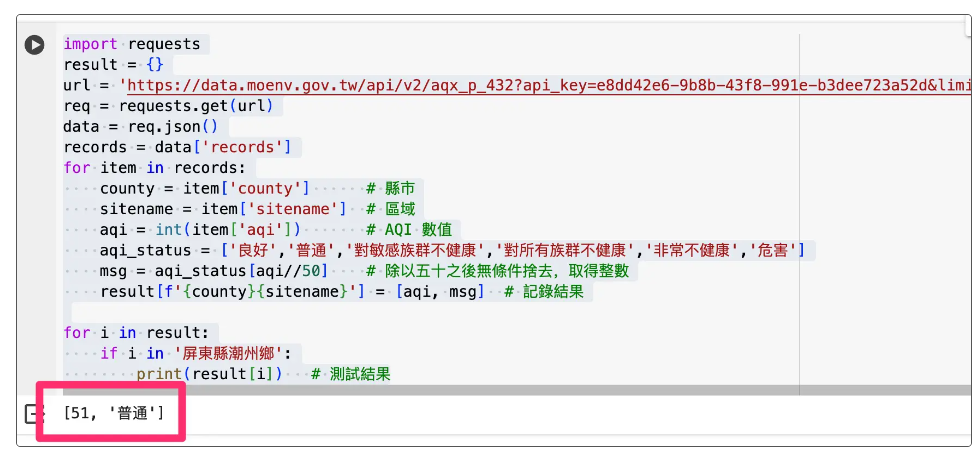

In [ ]:
import requests
result = {}
url = 'https://data.moenv.gov.tw/api/v2/aqx_p_432?api_key=e8dd42e6-9b8b-43f8-991e-b3dee723a52d&limit=1000&sort=ImportDate%20desc&format=JSON'
req = requests.get(url)
data = req.json()
records = data['records']
for item in records:
    county = item['county']      # 縣市
    sitename = item['sitename']  # 區域
    aqi = int(item['aqi'])       # AQI 數值
    aqi_status = ['良好','普通','對敏感族群不健康','對所有族群不健康','非常不健康','危害']
    msg = aqi_status[aqi//50]    # 除以五十之後無條件捨去，取得整數
    result[f'{county}{sitename}'] = [aqi, msg]  # 記錄結果

for i in result:
    if i in '屏東縣潮州鄉':
        print(result[i])   # 測試結果

##### 整合氣象預報與空氣品質 
將氣象預報函式、空氣品質程式與原本的程式結合，同樣都使用「縣市+區域」的方式作為 result 的 key，先抓取即時氣象，\
接著抓取氣象預報，如果即時氣象的 key 已經存在就添加內容，如果不存在就額外建立一組 key。

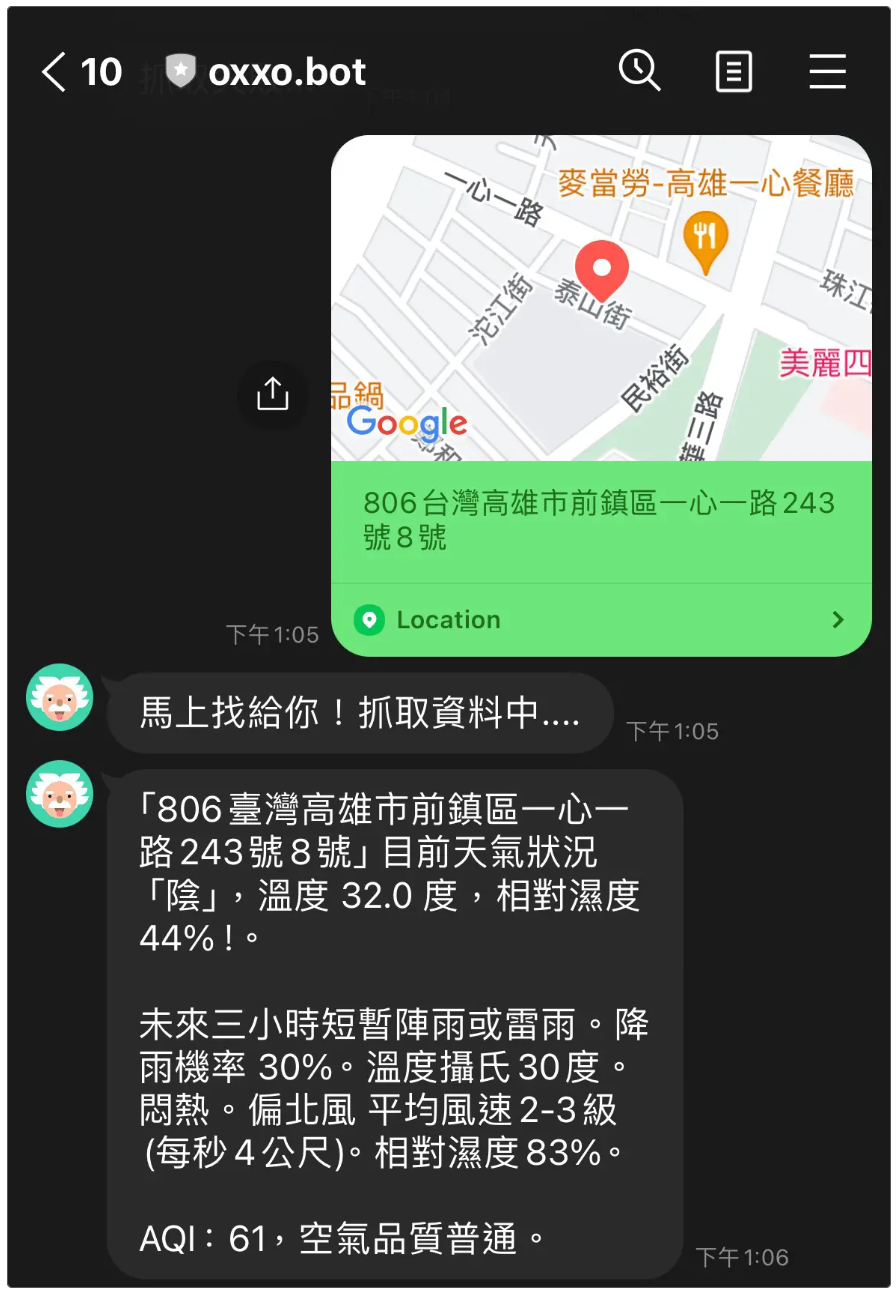

In [ ]:
from flask import Flask, request
from pyngrok import ngrok   # Colab 環境需要，本機環境不需要
import math, json, time, requests


# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

app = Flask(__name__)

# Colab 環境需要下面這三行，本機環境不需要
port = "5000"
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

def earth_quake():
    result = []
    code = '你的 token'
    try:
        # 小區域 https://opendata.cwa.gov.tw/dataset/earthquake/E-A0016-001
        url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0016-001?Authorization={code}'
        req1 = requests.get(url)  # 爬取資料
        data1 = req1.json()       # 轉換成 json
        eq1 = data1['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t1 = data1['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        # 顯著有感 https://opendata.cwa.gov.tw/dataset/all/E-A0015-001
        url2 = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0015-001?Authorization={code}'
        req2 = requests.get(url2)  # 爬取資料
        data2 = req2.json()        # 轉換成 json
        eq2 = data2['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t2 = data2['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        
        result = [eq1['ReportContent'], eq1['ReportImageURI']] # 先使用小區域地震
        if t2>t1:
          result = [eq2['ReportContent'], eq2['ReportImageURI']] # 如果顯著有感地震時間較近，就用顯著有感地震
    except Exception as e:
        print(e)
        result = ['抓取失敗...','']
    return result

def weather(address):
    result = {}
    code = '你的氣象 token'
    # 即時天氣
    try:
        url = [f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0001-001?Authorization={code}',
            f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0003-001?Authorization={code}']
        for item in url:
            req = requests.get(item)   # 爬取目前天氣網址的資料
            data = req.json()
            station = data['records']['Station']
            for i in station:
                city = i['GeoInfo']['CountyName']
                area = i['GeoInfo']['TownName']
                if not f'{city}{area}' in result:
                    weather = i['WeatherElement']['Weather']
                    temp = i['WeatherElement']['AirTemperature']
                    humid = i['WeatherElement']['RelativeHumidity']
                    result[f'{city}{area}'] = f'目前天氣狀況「{weather}」，溫度 {temp} 度，相對濕度 {humid}%！'
    except:
        pass


    # 氣象預報
    api_list = {"宜蘭縣":"F-D0047-001","桃園市":"F-D0047-005","新竹縣":"F-D0047-009","苗栗縣":"F-D0047-013",
        "彰化縣":"F-D0047-017","南投縣":"F-D0047-021","雲林縣":"F-D0047-025","嘉義縣":"F-D0047-029",
        "屏東縣":"F-D0047-033","臺東縣":"F-D0047-037","花蓮縣":"F-D0047-041","澎湖縣":"F-D0047-045",
        "基隆市":"F-D0047-049","新竹市":"F-D0047-053","嘉義市":"F-D0047-057","臺北市":"F-D0047-061",
        "高雄市":"F-D0047-065","新北市":"F-D0047-069","臺中市":"F-D0047-073","臺南市":"F-D0047-077",
        "連江縣":"F-D0047-081","金門縣":"F-D0047-085"}
    for name in api_list:
        if name in address:
            city_id = api_list[name]
    t = time.time()
    t1 = time.localtime(t+28800)
    t2 = time.localtime(t+28800+10800)
    now = time.strftime('%Y-%m-%dT%H:%M:%S',t1)
    now2 = time.strftime('%Y-%m-%dT%H:%M:%S',t2)
    url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/{city_id}?Authorization={code}&elementName=WeatherDescription&timeFrom={now}&timeTo={now2}'
    req = requests.get(url)   # 取得主要縣市預報資料
    data = req.json()         # json 格式化訊息內容
    location = data['records']['locations'][0]['location']
    city = data['records']['locations'][0]['locationsName']
    for item in location:
        try:
            area = item['locationName']
            note = item['weatherElement'][0]['time'][0]['elementValue'][0]['value']
            if not f'{city}{area}' in result:
                result[f'{city}{area}'] = ''
            else:
                result[f'{city}{area}'] = result[f'{city}{area}'] + '。\n\n'
            result[f'{city}{area}'] = result[f'{city}{area}'] + '未來三小時' + note
        except:
            pass

    # 空氣品質
    try:
        url = 'https://data.moenv.gov.tw/api/v2/aqx_p_432?api_key=e8dd42e6-9b8b-43f8-991e-b3dee723a52d&limit=1000&sort=ImportDate%20desc&format=JSON'
        req = requests.get(url)
        data = req.json()
        records = data['records']
        for item in records:
            county = item['county']      # 縣市
            sitename = item['sitename']  # 區域
            name = f'{county}{sitename}'
            aqi = int(item['aqi'])       # AQI 數值
            aqi_status = ['良好','普通','對敏感族群不健康','對所有族群不健康','非常不健康','危害']
            msg = aqi_status[aqi//50]    # 除以五十之後無條件捨去，取得整數

            for k in result:
                if name in k:
                    result[k] = result[k] + f'\n\nAQI：{aqi}，空氣品質{msg}。'
    except:
        pass

    output = '找不到氣象資訊'
    for i in result:
        if i in address: # 如果地址裡存在 key 的名稱
            output = f'「{address}」{result[i]}'
            break
    return output

def cctv(msg):
    try:
        output = ''
        camera_list = {
            '夢時代':'https://cctv1.kctmc.nat.gov.tw/27e5c086/',
            '鼓山渡輪站':'https://cctv3.kctmc.nat.gov.tw/ddb9fc98/',
            '中正交流道':'https://cctv3.kctmc.nat.gov.tw/166157d9/',
            '五福愛河':'https://cctv4.kctmc.nat.gov.tw/335e2702/'
        }
        for item in camera_list:
            if msg == item:
                output = camera_list[msg]
    except Exception as e:
        print(e)
    return output



access_token = '你的 ACCESS TOKEN'
channel_secret = '你的 Channel Secret'

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        line_bot_api = LineBotApi(access_token)     # 確認 token 是否正確
        handler = WebhookHandler(channel_secret)    # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']             # 加入回傳的 headers
        handler.handle(body, signature)      # 綁定訊息回傳的相關資訊
        json_data = json.loads(body)         # 轉換內容為 json 格式
        reply_token = json_data['events'][0]['replyToken']    # 取得回傳訊息的 Token ( reply message 使用 )
        user_id = json_data['events'][0]['source']['userId']  # 取得使用者 ID ( push message 使用 )
        print(json_data)                                      # 印出內容
        type = json_data['events'][0]['message']['type']
        if type == 'text':
            text = json_data['events'][0]['message']['text']
            if text == '雷達回波圖' or text == '雷達回波':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                img_url = f'https://cwaopendata.s3.ap-northeast-1.amazonaws.com/Observation/O-A0058-001.png?{time.time_ns()}'
                img_message = ImageSendMessage(original_content_url=img_url, preview_image_url=img_url)
                line_bot_api.reply_message(reply_token,img_message)
            elif text == '地震':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                reply = earth_quake()
                text_message = TextSendMessage(text=reply[0])
                line_bot_api.reply_message(reply_token,text_message)
                line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply[1], preview_image_url=reply[1]))
            else:
                reply = cctv(text)
                if not reply == '':
                    text_message = TextSendMessage(text=reply)
                    line_bot_api.reply_message(reply_token,text_message)
                    sec = math.ceil(time.time())
                    reply = reply + f'snapshot?t={sec}'
                    line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply, preview_image_url=reply))
                else:
                    text_message = TextSendMessage(text=text)
                    line_bot_api.reply_message(reply_token,text_message)
        elif type == 'location':
            line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
            address = json_data['events'][0]['message']['address'].replace('台','臺')  # 取出地址資訊，並將「台」換成「臺」
            reply = weather(address)
            text_message = TextSendMessage(text=reply)
            line_bot_api.reply_message(reply_token,text_message)
    except Exception as e:
        print(e)
    return 'OK'                 # 驗證 Webhook 使用，不能省略

if __name__ == "__main__":
    app.run()

##### 小結 
到這個步驟，已經完成了一個 LINE 的氣象機器人，最後只需要加入圖文選單，提升使用者體驗就可以囉～

完整範例程式下載：[line-bot-weather.py](https://steam.oxxostudio.tw/download/python/line-bot-weather.py)

完整範例程式如下:

In [3]:
from flask import Flask, request
# from pyngrok import ngrok   # Colab 環境需要，本機環境不需要
import math, json, time, requests


# 載入 LINE Message API 相關函式庫
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import MessageEvent, TextMessage, TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage

app = Flask(__name__)

# Colab 環境需要下面這三行，本機環境不需要
# port = "5000"
# public_url = ngrok.connect(port).public_url
# print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\" ")

def earth_quake():
    result = []
    code = 'l7Ri22mpL431SIYQKAGs0iMJz1X5c9w'
    try:
        # 小區域 https://opendata.cwa.gov.tw/dataset/earthquake/E-A0016-001
        url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0016-001?Authorization={code}'
        req1 = requests.get(url)  # 爬取資料
        data1 = req1.json()       # 轉換成 json
        eq1 = data1['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t1 = data1['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        # 顯著有感 https://opendata.cwa.gov.tw/dataset/all/E-A0015-001
        url2 = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/E-A0015-001?Authorization={code}'
        req2 = requests.get(url2)  # 爬取資料
        data2 = req2.json()        # 轉換成 json
        eq2 = data2['records']['Earthquake'][0]           # 取得第一筆地震資訊
        t2 = data2['records']['Earthquake'][0]['EarthquakeInfo']['OriginTime']
        
        result = [eq1['ReportContent'], eq1['ReportImageURI']] # 先使用小區域地震
        if t2>t1:
            result = [eq2['ReportContent'], eq2['ReportImageURI']] # 如果顯著有感地震時間較近，就用顯著有感地震
    except Exception as e:
        print(e)
        result = ['抓取失敗...','']
    return result

def weather(address):
    result = {}
    code = '你的氣象 token'
    # 即時天氣
    try:
        url = [f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0001-001?Authorization={code}',
            f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/O-A0003-001?Authorization={code}']
        for item in url:
            req = requests.get(item)   # 爬取目前天氣網址的資料
            data = req.json()
            station = data['records']['Station']
            for i in station:
                city = i['GeoInfo']['CountyName']
                area = i['GeoInfo']['TownName']
                if not f'{city}{area}' in result:
                    weather = i['WeatherElement']['Weather']
                    temp = i['WeatherElement']['AirTemperature']
                    humid = i['WeatherElement']['RelativeHumidity']
                    result[f'{city}{area}'] = f'目前天氣狀況「{weather}」，溫度 {temp} 度，相對濕度 {humid}%！'
    except:
        pass


    # 氣象預報
    api_list = {"宜蘭縣":"F-D0047-001","桃園市":"F-D0047-005","新竹縣":"F-D0047-009","苗栗縣":"F-D0047-013",
        "彰化縣":"F-D0047-017","南投縣":"F-D0047-021","雲林縣":"F-D0047-025","嘉義縣":"F-D0047-029",
        "屏東縣":"F-D0047-033","臺東縣":"F-D0047-037","花蓮縣":"F-D0047-041","澎湖縣":"F-D0047-045",
        "基隆市":"F-D0047-049","新竹市":"F-D0047-053","嘉義市":"F-D0047-057","臺北市":"F-D0047-061",
        "高雄市":"F-D0047-065","新北市":"F-D0047-069","臺中市":"F-D0047-073","臺南市":"F-D0047-077",
        "連江縣":"F-D0047-081","金門縣":"F-D0047-085"}
    for name in api_list:
        if name in address:
            city_id = api_list[name]
    t = time.time()
    t1 = time.localtime(t+28800)
    t2 = time.localtime(t+28800+10800)
    now = time.strftime('%Y-%m-%dT%H:%M:%S',t1)
    now2 = time.strftime('%Y-%m-%dT%H:%M:%S',t2)
    url = f'https://opendata.cwa.gov.tw/api/v1/rest/datastore/{city_id}?Authorization={code}&elementName=WeatherDescription&timeFrom={now}&timeTo={now2}'
    req = requests.get(url)   # 取得主要縣市預報資料
    data = req.json()         # json 格式化訊息內容
    location = data['records']['locations'][0]['location']
    city = data['records']['locations'][0]['locationsName']
    for item in location:
        try:
            area = item['locationName']
            note = item['weatherElement'][0]['time'][0]['elementValue'][0]['value']
            if not f'{city}{area}' in result:
                result[f'{city}{area}'] = ''
            else:
                result[f'{city}{area}'] = result[f'{city}{area}'] + '。\n\n'
            result[f'{city}{area}'] = result[f'{city}{area}'] + '未來三小時' + note
        except:
            pass

    # 空氣品質
    try:
        url = 'https://data.moenv.gov.tw/api/v2/aqx_p_432?api_key=e8dd42e6-9b8b-43f8-991e-b3dee723a52d&limit=1000&sort=ImportDate%20desc&format=JSON'
        req = requests.get(url)
        data = req.json()
        records = data['records']
        for item in records:
            county = item['county']      # 縣市
            sitename = item['sitename']  # 區域
            name = f'{county}{sitename}'
            aqi = int(item['aqi'])       # AQI 數值
            aqi_status = ['良好','普通','對敏感族群不健康','對所有族群不健康','非常不健康','危害']
            msg = aqi_status[aqi//50]    # 除以五十之後無條件捨去，取得整數

            for k in result:
                if name in k:
                    result[k] = result[k] + f'\n\nAQI：{aqi}，空氣品質{msg}。'
    except:
        pass

    output = '找不到氣象資訊'
    for i in result:
        if i in address: # 如果地址裡存在 key 的名稱
            output = f'「{address}」{result[i]}'
            break
    return output

def cctv(msg):
    try:
        output = ''
        camera_list = {
            '夢時代':'https://cctv1.kctmc.nat.gov.tw/27e5c086/',
            '鼓山渡輪站':'https://cctv3.kctmc.nat.gov.tw/ddb9fc98/',
            '中正交流道':'https://cctv3.kctmc.nat.gov.tw/166157d9/',
            '五福愛河':'https://cctv4.kctmc.nat.gov.tw/335e2702/'
        }
        for item in camera_list:
            if msg == item:
                output = camera_list[msg]
    except Exception as e:
        print(e)
    return output



access_token = 'l7Ri22mpL431SIYQKAGs0iMJz1X5c9weXz'
channel_secret = 'f2506993c71'

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)                    # 取得收到的訊息內容
    try:
        line_bot_api = LineBotApi(access_token)     # 確認 token 是否正確
        handler = WebhookHandler(channel_secret)    # 確認 secret 是否正確
        signature = request.headers['X-Line-Signature']             # 加入回傳的 headers
        handler.handle(body, signature)      # 綁定訊息回傳的相關資訊
        json_data = json.loads(body)         # 轉換內容為 json 格式
        reply_token = json_data['events'][0]['replyToken']    # 取得回傳訊息的 Token ( reply message 使用 )
        user_id = json_data['events'][0]['source']['userId']  # 取得使用者 ID ( push message 使用 )
        print(json_data)                                      # 印出內容
        type = json_data['events'][0]['message']['type']
        if type == 'text':
            text = json_data['events'][0]['message']['text']
            if text == '雷達回波圖' or text == '雷達回波':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                img_url = f'https://cwaopendata.s3.ap-northeast-1.amazonaws.com/Observation/O-A0058-001.png?{time.time_ns()}'
                img_message = ImageSendMessage(original_content_url=img_url, preview_image_url=img_url)
                line_bot_api.reply_message(reply_token,img_message)
            elif text == '地震':
                line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
                reply = earth_quake()
                text_message = TextSendMessage(text=reply[0])
                line_bot_api.reply_message(reply_token,text_message)
                line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply[1], preview_image_url=reply[1]))
            else:
                reply = cctv(text)
                if not reply == '':
                    text_message = TextSendMessage(text=reply)
                    line_bot_api.reply_message(reply_token,text_message)
                    sec = math.ceil(time.time())
                    reply = reply + f'snapshot?t={sec}'
                    line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply, preview_image_url=reply))
                else:
                    text_message = TextSendMessage(text=text)
                    line_bot_api.reply_message(reply_token,text_message)
        elif type == 'location':
            line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
            address = json_data['events'][0]['message']['address'].replace('台','臺')  # 取出地址資訊，並將「台」換成「臺」
            reply = weather(address)
            text_message = TextSendMessage(text=reply)
            line_bot_api.reply_message(reply_token,text_message)
    except Exception as e:
        print(e)
    return 'OK'                 # 驗證 Webhook 使用，不能省略

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:150: LineBotSdkDeprecatedIn30: Call to deprecated class LineBotApi. (Use v3 class; linebot.v3.<feature>. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api = LineBotApi(access_token)     # 確認 token 是否正確
C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:151: LineBotSdkDeprecatedIn30: Call to deprecated class WebhookHandler. (Use 'from linebot.v3.webhook import WebhookHandler' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  handler = WebhookHandler(channel_secret)    # 確認 secret 是否正確
C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:182: LineBotSdkDeprecatedIn30: Call to deprecated method reply_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'Messagi

{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519152771074359633', 'quoteToken': 'WtcgKB7RGs1YWkDPkGeWyO1_B-DvXQEXJwYmSg8ougX5PQBKAdpKvg56SUfz7F4UQrR9WXn6FU4LrNPqX6pa5MkriLuOp2-UvXHIcj0IEEdwnmLROO3sVB4wcraxUL_qq2rZKZfpRTJbGzGEQnK-XQ', 'text': 'location'}, 'webhookEventId': '01J3ZN3KDTGZNDV3Y0MNT4X69C', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722270469056, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '650076e3631a40a9b8185a6cf098d5ad', 'mode': 'active'}]}


127.0.0.1 - - [30/Jul/2024 00:27:49] "POST / HTTP/1.1" 200 -


{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519152788203897169', 'quoteToken': 'JmxazZkKezJRkdOCrr6_6jD39ZLFgjWCfg-x93PH0yaQYIVYz0Zh3hwx8Z82_JhewkKGKFW5BE6g-l5EXGkMFPIh9zfW5wTdskZUhrM3rLbxTIJvbFQUz1BP-GH7akDMyevibflryQLMrWwpSXPOMQ', 'text': '地震'}, 'webhookEventId': '01J3ZN3X8SGDZ02CGYFXKQENYT', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722270479267, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '1a024d33a8e249f3b6d62437d41c7780', 'mode': 'active'}]}


C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:167: LineBotSdkDeprecatedIn30: Call to deprecated method push_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).push_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))


Extra data: line 1 column 5 (char 4)


C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:170: LineBotSdkDeprecatedIn30: Call to deprecated method reply_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).reply_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.reply_message(reply_token,text_message)
C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:171: LineBotSdkDeprecatedIn30: Call to deprecated method push_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).push_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply[1], preview_image_url=reply[1]))
127.0.0.1 - - [30/Jul/2024 00:28:00] "POST / HTTP/1.1" 200 -


LineBotApiError: status_code=400, request_id=55228369-3ed6-48a3-8cc0-0b90e30908b0, error_response={"details": [{"message": "May not be empty", "property": "messages[0].originalContentUrl"}, {"message": "May not be empty", "property": "messages[0].previewImageUrl"}], "message": "The request body has 2 error(s)"}, headers={'Server': 'legy', 'Content-Type': 'application/json', 'x-content-type-options': 'nosniff', 'x-frame-options': 'DENY', 'x-line-request-id': '55228369-3ed6-48a3-8cc0-0b90e30908b0', 'x-xss-protection': '1; mode=block', 'Content-Length': '204', 'Expires': 'Mon, 29 Jul 2024 16:28:01 GMT', 'Cache-Control': 'max-age=0, no-cache, no-store', 'Pragma': 'no-cache', 'Date': 'Mon, 29 Jul 2024 16:28:01 GMT', 'Connection': 'close'}
{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519152912623206626', 'quoteToken': 'NZtkDt37wjT_t7HALihS94bXgxkAtaaml1xmuBa-Uegv8BqcvzkcO92WMNQYptOjIjVRh3PdY_aKd0-5QghyF4etjw6Q4gppzmqXF

C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:162: LineBotSdkDeprecatedIn30: Call to deprecated method push_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).push_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.push_message(user_id, TextSendMessage(text='馬上找給你！抓取資料中....'))
C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:165: LineBotSdkDeprecatedIn30: Call to deprecated method reply_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).reply_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.reply_message(reply_token,img_message)
127.0.0.1 - - [30/Jul/2024 00:29:13] "POST / HTTP/1.1" 200 -


{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519152964901011646', 'quoteToken': 'LH15BqGS4Kv7x8nYAEmR5MCVnJ4d4wvJHzsco63tQZK8Wr5ucgQi7QDUlpxZPsXqToRvcyfi9RTDJP1YRFbaC1JimWW5Q5CboZFq0hSU4FI7c5Y3cgMSaXp7yEkvPIhK0bd3pjS3xkMF2jXh5B_mYw', 'text': 'cctv'}, 'webhookEventId': '01J3ZN7495C0G51WNWZ0Z7SHS5', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722270584764, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '70cac7aaaf2a4a0d849f887489259714', 'mode': 'active'}]}


127.0.0.1 - - [30/Jul/2024 00:29:44] "POST / HTTP/1.1" 200 -


{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519153131968528774', 'quoteToken': 'YV5jfKSwLiaSD9nKeUL5QzIw5-wQtO2eiJXRnp57rWj2vgdElUER0BAoxUEWHhVOaWkulkUnUWKzTdypULXgfFapca7iwsDD-39sjdZSB_UiQuPeINwDELu1xNVLSGzm2u3xKVLb5yLIkkdYXE31nA', 'text': '中正交流道'}, 'webhookEventId': '01J3ZNA5KSVBSFMGEP34F3JT2H', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722270684286, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '8332a7da451f473db0440b4fefbb0186', 'mode': 'active'}]}


C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:176: LineBotSdkDeprecatedIn30: Call to deprecated method reply_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).reply_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.reply_message(reply_token,text_message)
C:\Users\cgiks\AppData\Local\Temp\ipykernel_17056\3984778826.py:179: LineBotSdkDeprecatedIn30: Call to deprecated method push_message. (Use 'from linebot.v3.messaging import MessagingApi' and 'MessagingApi(...).push_message(...)' instead. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api.push_message(user_id, ImageSendMessage(original_content_url=reply, preview_image_url=reply))
127.0.0.1 - - [30/Jul/2024 00:31:24] "POST / HTTP/1.1" 200 -


{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519153276051784001', 'quoteToken': 'V-tpA01K6Tx9w2_LBAtZ2oOyzypO4hrtOKyy37kai14WQtWOJtNH0GuoMOiq2EmX8J9PC_NnG270Vj_mHA4oXW0K6__dLHX9HCPxk1fD2z_h6QuP7MHFbWlr_bdqpF27W40UuRfH5ZrcOr5gl4mXpQ', 'text': '高雄市'}, 'webhookEventId': '01J3ZNCS6YRCK9H02DT2HTKSPC', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722270770049, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '4f79d238875f41379e42d1c9ffc2710a', 'mode': 'active'}]}


127.0.0.1 - - [30/Jul/2024 00:32:50] "POST / HTTP/1.1" 200 -


{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519153297358848353', 'quoteToken': 'tj3JnQbxb31fc5FqROX7FDEhC5MKgSEZvkBRo3NajndqY1qoARGoWrOAJ20RIMxrL7Fdo8lWBjg0FP0LyI1Te0anFzY49UASLaxhdyp75cGxA663uMoobnXIGADbU3gSTSf-g9-gEg_llabeHTR2Zw', 'text': '高雄市仁武區'}, 'webhookEventId': '01J3ZND5ETHSKBXQYF9JJR0AQ5', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722270782748, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '8a4e401de2524825907e1b0be59624db', 'mode': 'active'}]}


127.0.0.1 - - [30/Jul/2024 00:33:02] "POST / HTTP/1.1" 200 -
